# Stats

This notebook loads some data, reports some simple descriptive statistics (means, standard deviations etc) and shows a number of useful plots (scatter plots, histograms, time series plots).

Most of the descriptive stats use the standard package Statistics. The plots rely on the Plots package and the pdf and quantiles are from the [Distributions](https://github.com/JuliaStats/Distributions.jl) package.

## Load Packages

In [1]:
using Statistics, Dates, LinearAlgebra, DelimitedFiles, Distributions
                         
include("printmat.jl")   #just a function for prettier matrix printing

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))    
gr(size=(480,320))
default(fmt = :svg)        

# Load Data from a csv File

The following is a portion of MyData.csv:

```
date,Mkt-RF,RF,SmallGrowth
197901,4.18,0.77,10.96
197902,-3.41,0.73,-2.09
197903,5.75,0.81,11.71
197904,0.05,0.8,3.27
```

In [3]:
x = readdlm("Data/MyData.csv",',',skipstart=1)  #reading the csv file    
                                                #skip 1st line
println("\nfirst four lines of x:") 
printmat(x[1:4,:])


first four lines of x:
197901.000     4.180     0.770    10.960
197902.000    -3.410     0.730    -2.090
197903.000     5.750     0.810    11.710
197904.000     0.050     0.800     3.270



### Creating Variables

In [4]:
ym  = round.(Int,x[:,1])             #yearmonth, like 200712
(Rme,Rf,R) = (x[:,2],x[:,3],x[:,4])  #creating variables from columns of x
Re  = R - Rf                         #do R .- Rf if R has several columns

println("first 4 obs of Rme and Re")
printmat([Rme[1:4,:] Re[1:4,:]])

dN = Date.(string.(ym),"yyyymm") #convert to string and then to Julia Date
printmat(dN[1:4])

first 4 obs of Rme and Re
     4.180    10.190
    -3.410    -2.820
     5.750    10.900
     0.050     2.470

1979-01-01
1979-02-01
1979-03-01
1979-04-01



# Some Descriptive Statistics

## Means and Standard Deviations

The next few cells estimate means, standard deviations, covariances and correlations of the variables `Rme` (US equity market excess return) and `Re` (excess returns for a segment of the market, small growth firms). 

In [5]:
μ = mean([Rme Re],dims=1)    #,dims=1 to calculate average along a column
σ = std([Rme Re],dims=1)     #do \sigma[Tab] to get σ


println("            Rme       Re")
printlnPs("means: ",μ)  #for more stat functions, see the package StatsBase.jl
printlnPs("std:   ",σ)

            Rme       Re
   means:      0.602     0.303
   std:        4.604     8.572


## Covariances and Correlations

In [6]:
println("\n","cov([Rme Re]): ")          
printmat(cov([Rme Re]))

println("\n","cor([Rme Re]): ")          
printmat(cor([Rme Re]))


cov([Rme Re]): 
    21.197    28.426
    28.426    73.475


cor([Rme Re]): 
     1.000     0.720
     0.720     1.000



## OLS

A linear regression
$
y = x'b + u
$,
where $x=[1;R^e_m]$.

Clearly, the first element of $b$ is the intercept and the second element is the slope coefficient.

The GLM package (not used here) has powerful regression methods. See https://github.com/JuliaStats/GLM.jl.

In [7]:
c   = ones(size(Rme,1))         #a vector with ones, no. rows from variable
x   = [c Rme]                   #x is a Tx2 matrix
y   = copy(Re)                  #to get standard OLS notation

b2  = inv(x'x)*x'y              #OLS according to a textbook
b   = x\y                       #also OLS, quicker and numerically more stable
u   = y - x*b                   #OLS residuals
R2a = 1 - var(u)/var(y)         #R2, but that name is already taken

Covb  = inv(x'x)*var(u)         #covariance matrix of b estimates
Stdb  = sqrt.(diag(Covb))       #std of b estimates
tstat = (b .- 0)./Stdb          #t-stats, replace 0 with your null hypothesis 

println("OLS coefficients, regressing Re on constant and Rme, different calculations")
printmat([b b2])                
printlnPs("R2: ",R2a) 
printlnPs("no. of observations: ",size(Re,1))

println("\ncoeffs and t-stats")
printmat([b tstat])

OLS coefficients, regressing Re on constant and Rme, different calculations
    -0.504    -0.504
     1.341     1.341

      R2:      0.519
no. of observations:        388

coeffs and t-stats
    -0.504    -1.656
     1.341    20.427



# Drawing Random Numbers and Finding Critical Values

## Random Numbers: Independent Variables

In [8]:
T = 100
x = randn(T,2)    #T x 2 matrix, N(0,1) distribution

println("\n","mean and std of random draws: ")
μ = mean(x,dims=1)        
σ = std(x,dims=1)
printmat([μ;σ])

println("covariance and correlation matrices:")
printmat(cov(x))
printmat(cor(x))


mean and std of random draws: 
    -0.025     0.211
     0.980     1.014

covariance and correlation matrices:
     0.960     0.039
     0.039     1.029

     1.000     0.039
     0.039     1.000



## Random Numbers: Correlated Variables

In [9]:
μ = [-1,10]          #vector of means
Σ = [1 0.5;          #covariance matrix
     0.5 2]

T = 100
x = rand(MvNormal(μ,Σ),T)'  #random numbers, T x 2, drawn from bivariate N(μ,Σ)

println("\n","mean and std of random draws: ")
μ = mean(x,dims=1)          
σ = std(x,dims=1)
printmat([μ;σ])

println("covariance and correlation matrices:")
printmat(cov(x))
printmat(cor(x))


mean and std of random draws: 
    -1.038     9.941
     0.993     1.374

covariance and correlation matrices:
     0.986     0.552
     0.552     1.887

     1.000     0.405
     0.405     1.000



## Quantiles ("critical values") of Distributions

In [10]:
N05     = quantile(Normal(0,1),0.05)            #from the Distributions package
Chisq05 = quantile(Chisq(5),0.95)

println("\n","5th percentile of N(0,1) and 95th of Chisquare(5)")      #lots of statistics functions
printmat([N05 Chisq05])


5th percentile of N(0,1) and 95th of Chisquare(5)
    -1.645    11.070



# Statistical Plots

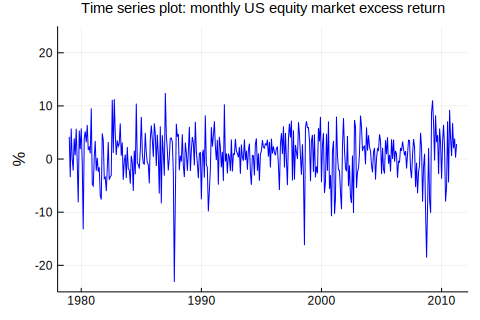

In [11]:
xTicksLoc = Dates.value.([Date(1980);Date(1990);Date(2000);Date(2010)])
xTicksLab = ["1980";"1990";"2000";"2010"]   #crude way of getting the tick marks right

plot( dN,Rme,
      color = :blue,
      legend = false,
      xticks = (xTicksLoc,xTicksLab),
      ylim = (-25,25),
      title = "Time series plot: monthly US equity market excess return",
      titlefont = font(10),
      ylabel = "%" )

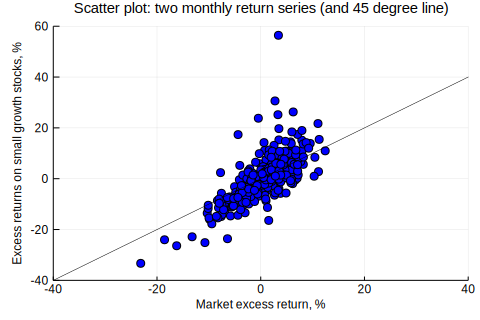

In [12]:
scatter( Rme,Re,
         color = :blue,
         legend = false,
         xlim = (-40,40),
         ylim = (-40,60),
         title = "Scatter plot: two monthly return series (and 45 degree line)",
         titlefont = font(10),
         xlabel = "Market excess return, %",
         ylabel = "Excess returns on small growth stocks, %",
         guidefont = font(8) )

plot!([-40;60],[-40;60],color=:black,linewidth=0.5)   #easier to keep this outside plot()

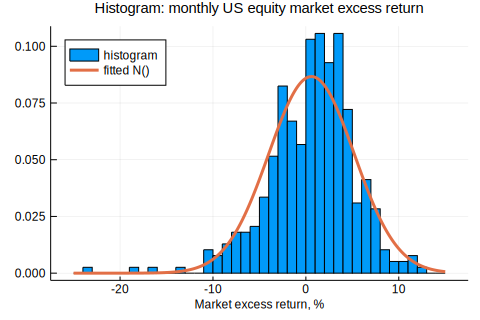

In [13]:
xGrid = -25:0.1:15
pdfX  = pdf.(Normal(mean(Rme),std(Rme)),xGrid) #"Distributions" wants σ, not σ^2                                       

histogram( Rme,bins = -25:1:15,
           normalized = true,     #normalized to have area=1
           label = "histogram",
           title = "Histogram: monthly US equity market excess return",
           titlefont = font(10),
           xlabel = "Market excess return, %",
           legend = :topleft,
           guidefont = font(8) )   #font size of axis labels   

plot!(xGrid,pdfX,linewidth=3,label="fitted N()")